In [1]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
config = read_config(
    os.path.join(GTE_DIR,'config_half.yaml'))
analyze_year=True
year=2022
global global_rmse
global_rmse = config["Global_sqrt_mse"]
classifiacation_palette = ['#e41a1c', '#377eb8', "#4daf4a"]
# temperature_palette = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']
temperature_palette = ['#f1eef6','#d0d1e6','#a6bddb','#74a9cf','#2b8cbe','#045a8d']
classifiacation_palette = ['#e41a1c', '#377eb8', "#4daf4a"]
temperature_palette = ['#eff3ff','#c6dbef','#9ecae1','#6baed6','#3182bd','#08519c']

In [3]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'DJF'
    elif month in [3, 4, 5]:
        return 'MAM'
    elif month in [6, 7, 8]:
        return 'JJA'
    else:
        return 'SON'
if os.uname()[1]=="n2o":
    combined_cloud_df = pd.read_parquet(f"/wolke_scratch/dnikolo/Final_results/{year}_all.parquet")
    glaciations_df = pd.read_parquet(f"/wolke_scratch/dnikolo/Final_results/{year}_glac.parquet")
if os.uname()[1][:3]=="eu-":
    combined_cloud_df = pd.read_parquet(f"/cluster/work/climate/dnikolo/Cloud_analysis/full_years/{year}_all.parquet")
    glaciations_df = pd.read_parquet(f"/cluster/work/climate/dnikolo/Cloud_analysis/full_years/{year}_glac.parquet")
combined_cloud_df['Season'] = combined_cloud_df['track_start_time'].dt.month.apply(month_to_season)
glaciations_df["Radius [km]"]=np.sqrt(glaciations_df["avg_size[km]"]/np.pi)
glaciations_df['Season'] = glaciations_df['track_start_time'].dt.month.apply(month_to_season)
glaciating_clouds = glaciations_df.drop_duplicates(subset="Cloud_ID",keep="first")

Size distribution all vs glaciating

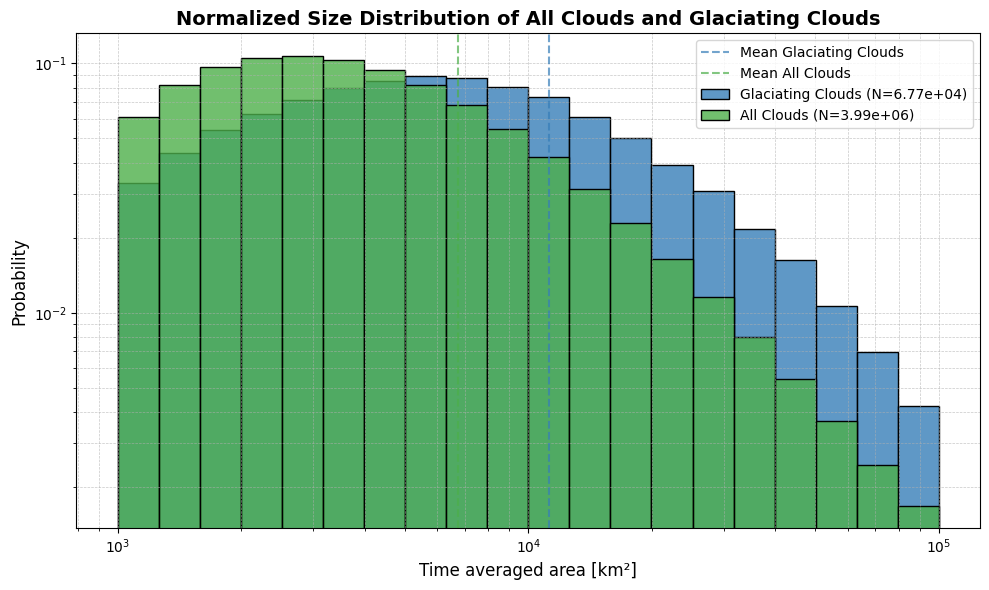

In [4]:
# Assuming `glaciating_clouds` and `combined_cloud_df` are preloaded DataFrames
mean_glaciating = glaciating_clouds['avg_size[km]'].mean()
mean_combined = combined_cloud_df['avg_size[km]'].mean()

f, ax = plt.subplots(figsize=(10, 6))  # Increased figure size for better readability

# Plot histograms
sns.histplot(
    data=glaciating_clouds,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=classifiacation_palette[1],
    stat="probability",
    label=f"Glaciating Clouds (N={len(glaciating_clouds):.2e})",
    alpha=0.8  # Slight transparency for overlap visibility
)

sns.histplot(
    data=combined_cloud_df,
    ax=ax,
    x="avg_size[km]",
    log_scale=(True, False),
    binrange=(3, 5),
    bins=20,
    color=classifiacation_palette[2],
    stat="probability",
    label=f"All Clouds (N={len(combined_cloud_df):.2e})",
    alpha=0.8
)

# Add vertical lines for means
ax.axvline(mean_glaciating, linestyle="--", color=classifiacation_palette[1], linewidth=1.5, alpha=0.7, label="Mean Glaciating Clouds")
ax.axvline(mean_combined, color=classifiacation_palette[2], linestyle="--", linewidth=1.5, alpha=0.7, label="Mean All Clouds")

# Set logarithmic y-axis
ax.set_yscale("log")

# Beautify the plot
ax.set_title("Normalized Size Distribution of All Clouds and Glaciating Clouds", fontsize=14, weight="bold")
ax.set_xlabel("Time averaged area [km²]", fontsize=12)
ax.set_ylabel("Probability", fontsize=12)
ax.legend(fontsize=10)
ax.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()

# Save the figure
filename = os.path.join(GTE_DIR,"Result_graphs/Size_hist_all_vs_glac_normalized")
plt.savefig(filename + ".pdf", dpi=400)
plt.savefig(filename + ".png", dpi=400)

Glaciation occurance rate with temperature

/cluster/work/climate/dnikolo/dump/ipykernel_2377432/1872836546.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bin_ranges, y=occurrence_rate.values, palette=temperature_palette[::-1])  # Use a color palette for aesthetics


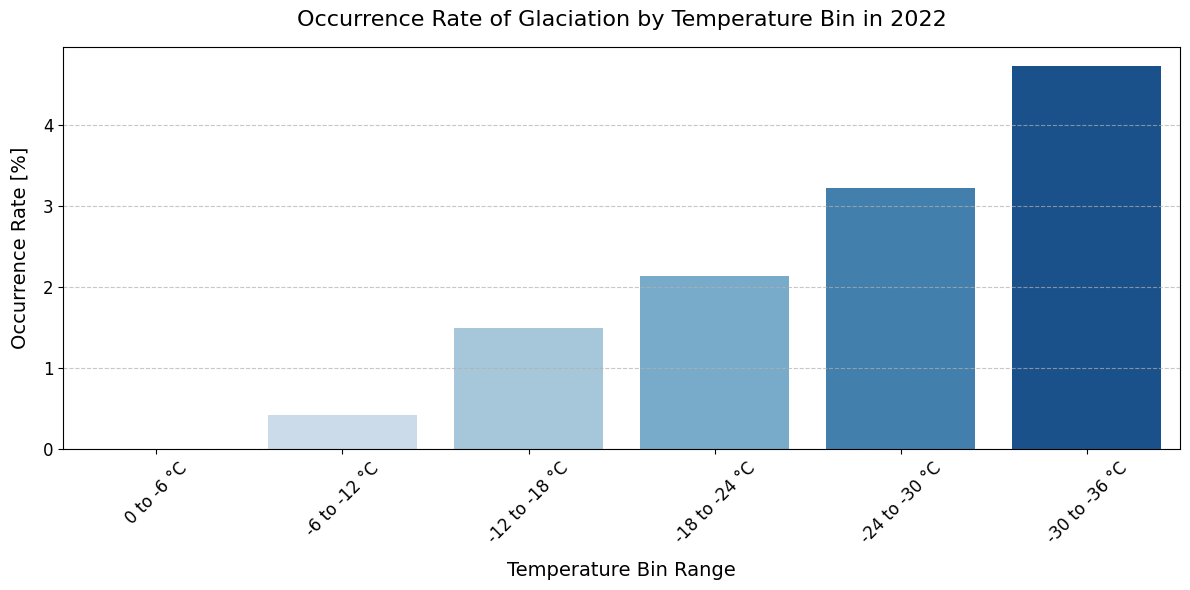

In [5]:
# Calculate occurrence rate
occurrence_rate = glaciating_clouds["min_temp"].value_counts(sort=False) / combined_cloud_df["min_temp"].value_counts(sort=False)*100

# Create bin ranges
bin_ranges = [f"{int(temp)+6} to {int(temp)} °C" for temp in occurrence_rate.index]

# Create the plot
plt.figure(figsize=(12, 6))  # Set figure size for better visual appeal
sns.barplot(x=bin_ranges, y=occurrence_rate.values, palette=temperature_palette[::-1])  # Use a color palette for aesthetics

# Customize grid
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines only on the y-axis with dashed lines

# Labeling
plt.xlabel("Temperature Bin Range", fontsize=14, labelpad=10)  # Font size and padding for x-label
plt.ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)  # Font size and padding for y-label
plt.title("Occurrence Rate of Glaciation by Temperature Bin in 2022", fontsize=16, pad=15)  # Add a title
plt.xticks(fontsize=12, rotation=45)  # Rotate x-ticks for better readability if needed
plt.yticks(fontsize=12)  # Adjust y-tick font size

# Invert x-axis
plt.gca().invert_xaxis()  # Invert the direction of the x-axis

# Show plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Glaciation_occurance_rates.png"),dpi=400)
plt.show()

Occurance rate by hemisphere 

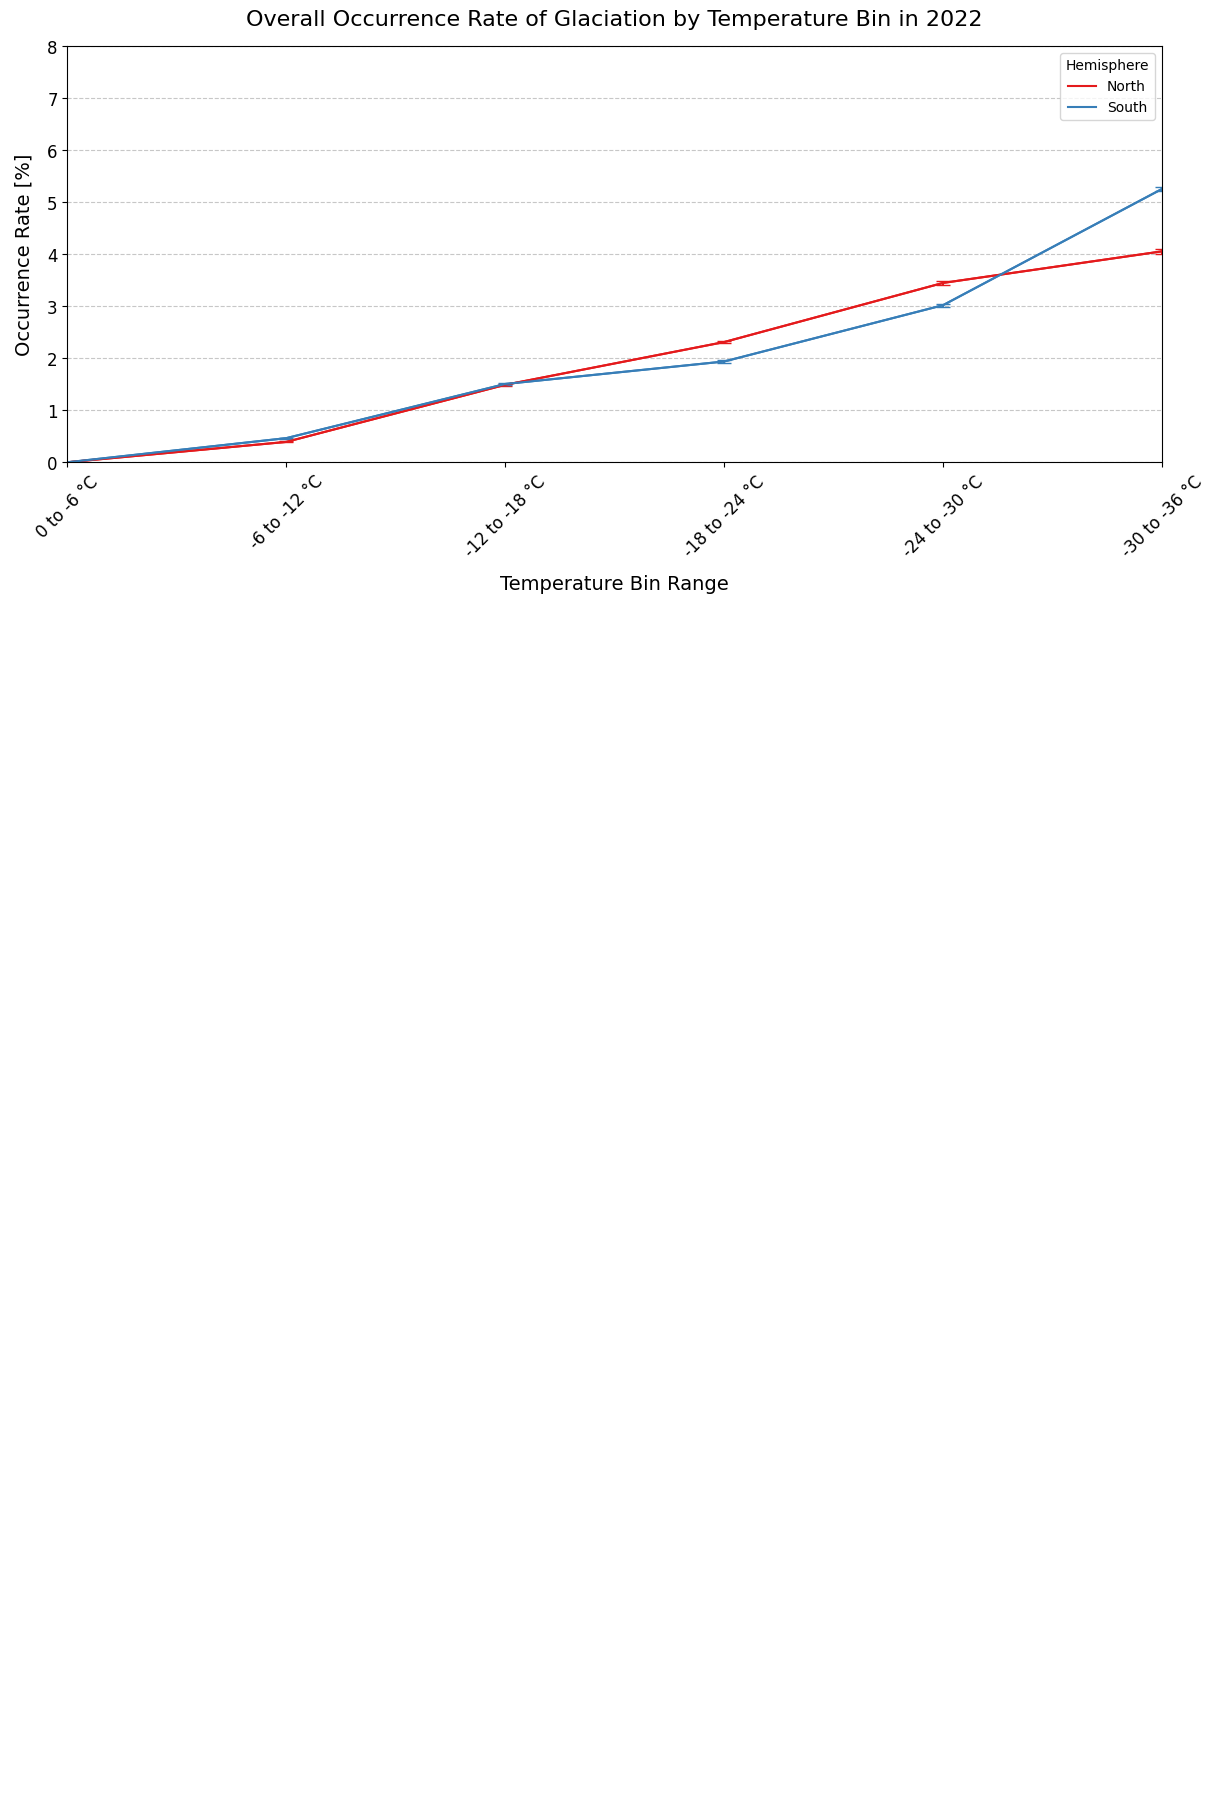

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Assuming glaciating_clouds, combined_cloud_df, classifiacation_palette, and GTE_DIR are already defined

# Define season-specific kernels
summer_glac_kernel = glaciating_clouds["Season"] == "JJA"
summer_comb_kernel = combined_cloud_df["Season"] == "JJA"

winter_glac_kernel = glaciating_clouds["Season"] == "DJF"
winter_comb_kernel = combined_cloud_df["Season"] == "DJF"

spring_glac_kernel = glaciating_clouds["Season"] == "MAM"
spring_comb_kernel = combined_cloud_df["Season"] == "MAM"

fall_glac_kernel = glaciating_clouds["Season"] == "SON"
fall_comb_kernel = combined_cloud_df["Season"] == "SON"

# Define hemisphere kernels
northern_glac_kernel = glaciating_clouds["Hemisphere"] == "North"
southern_glac_kernel = glaciating_clouds["Hemisphere"] == "South"
northern_comb_kernel = combined_cloud_df["Hemisphere"] == "North"
southern_comb_kernel = combined_cloud_df["Hemisphere"] == "South"

# Calculate overall occurrence rates
occurrence_rate_north = (
    glaciating_clouds[northern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south = (
    glaciating_clouds[southern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for JJA and DJF
occurrence_rate_north_summer = (
    glaciating_clouds[(northern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_summer = (
    glaciating_clouds[(southern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_winter = (
    glaciating_clouds[(northern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_winter = (
    glaciating_clouds[(southern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for MAM and SON
occurrence_rate_north_spring = (
    glaciating_clouds[(northern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_spring = (
    glaciating_clouds[(southern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_fall = (
    glaciating_clouds[(northern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_fall = (
    glaciating_clouds[(southern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Replace NaN values with 0
occurrence_rate_north = occurrence_rate_north.fillna(0)
occurrence_rate_south = occurrence_rate_south.fillna(0)
occurrence_rate_north_summer = occurrence_rate_north_summer.fillna(0)
occurrence_rate_south_summer = occurrence_rate_south_summer.fillna(0)
occurrence_rate_north_winter = occurrence_rate_north_winter.fillna(0)
occurrence_rate_south_winter = occurrence_rate_south_winter.fillna(0)
occurrence_rate_north_spring = occurrence_rate_north_spring.fillna(0)
occurrence_rate_south_spring = occurrence_rate_south_spring.fillna(0)
occurrence_rate_north_fall = occurrence_rate_north_fall.fillna(0)
occurrence_rate_south_fall = occurrence_rate_south_fall.fillna(0)

# Calculate error bars for overall occurrence rates
error_np = np.sqrt(occurrence_rate_north/100 * (1 - occurrence_rate_north/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="North"]["min_temp"].value_counts(sort=False)) * 100
error_sp = np.sqrt(occurrence_rate_south/100 * (1 - occurrence_rate_south/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="South"]["min_temp"].value_counts(sort=False)) * 100

# Create bin ranges for the x-axis
bin_ranges = [f"{int(temp+6)} to {int(temp)} °C" for temp in occurrence_rate_north.index]

# Create main figure with three subfigures
fig = plt.figure(constrained_layout=True, figsize=(12, 18))
subfigs = fig.subfigures(nrows=3, ncols=1)

# --- First Subfigure: Overall Occurrence Rates ---
ax1 = subfigs[0].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north.values, ax=ax1, label="North", color=classifiacation_palette[0])
sns.lineplot(x=bin_ranges, y=occurrence_rate_south.values, ax=ax1, label="South", color=classifiacation_palette[1])
ax1.errorbar(bin_ranges, occurrence_rate_north.values, yerr=error_np, color=classifiacation_palette[0], capsize=5)
ax1.errorbar(bin_ranges, occurrence_rate_south.values, yerr=error_sp, color=classifiacation_palette[1], capsize=5)
ax1.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax1.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax1.set_title("Overall Occurrence Rate of Glaciation by Temperature Bin in 2022", fontsize=16, pad=15)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelsize=12, rotation=45)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0,8)
ax1.set_xlim(0,5)
ax1.invert_xaxis()
ax1.legend(title="Hemisphere")

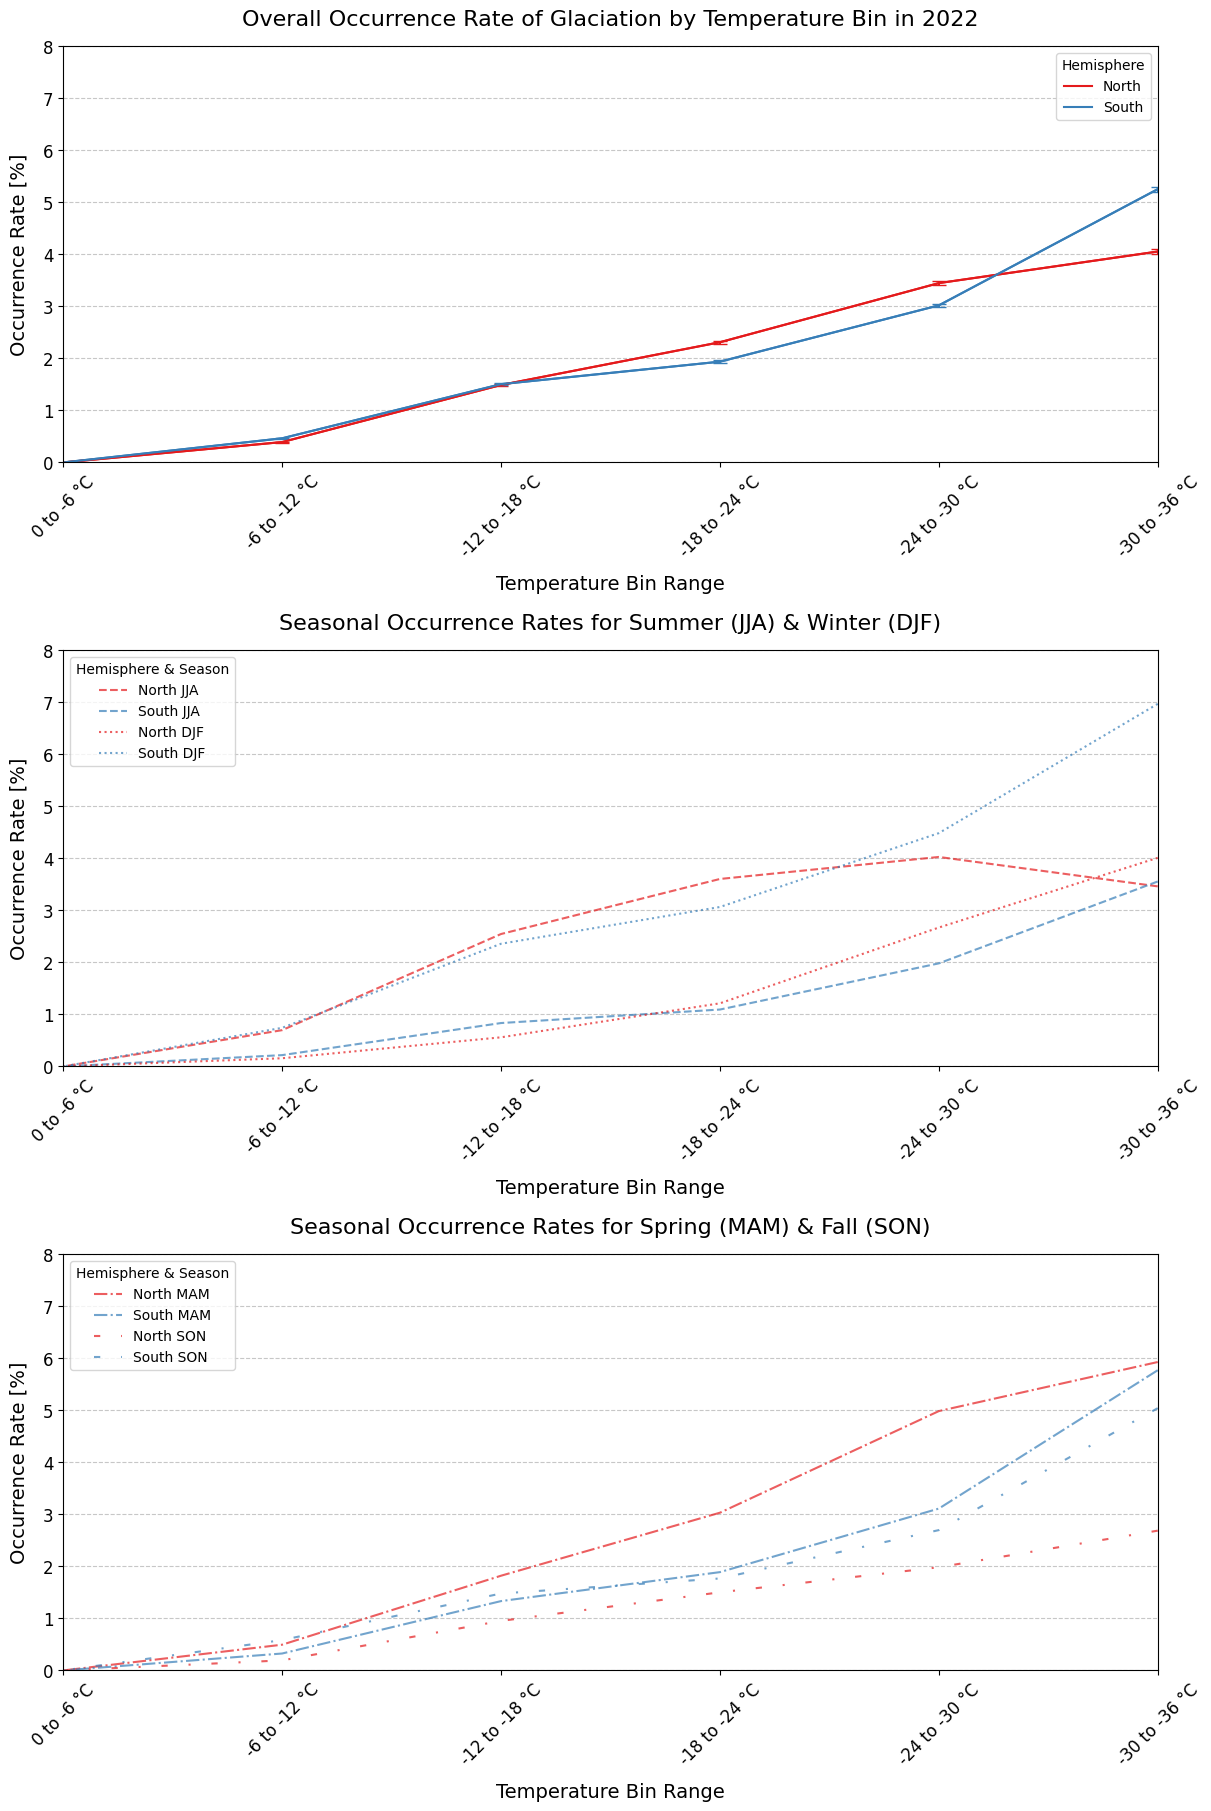

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Assuming glaciating_clouds, combined_cloud_df, classifiacation_palette, and GTE_DIR are already defined

# Define season-specific kernels
summer_glac_kernel = glaciating_clouds["Season"] == "JJA"
summer_comb_kernel = combined_cloud_df["Season"] == "JJA"

winter_glac_kernel = glaciating_clouds["Season"] == "DJF"
winter_comb_kernel = combined_cloud_df["Season"] == "DJF"

spring_glac_kernel = glaciating_clouds["Season"] == "MAM"
spring_comb_kernel = combined_cloud_df["Season"] == "MAM"

fall_glac_kernel = glaciating_clouds["Season"] == "SON"
fall_comb_kernel = combined_cloud_df["Season"] == "SON"

# Define hemisphere kernels
northern_glac_kernel = glaciating_clouds["Hemisphere"] == "North"
southern_glac_kernel = glaciating_clouds["Hemisphere"] == "South"
northern_comb_kernel = combined_cloud_df["Hemisphere"] == "North"
southern_comb_kernel = combined_cloud_df["Hemisphere"] == "South"

# Calculate overall occurrence rates
occurrence_rate_north = (
    glaciating_clouds[northern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south = (
    glaciating_clouds[southern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for JJA and DJF
occurrence_rate_north_summer = (
    glaciating_clouds[(northern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_summer = (
    glaciating_clouds[(southern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_winter = (
    glaciating_clouds[(northern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_winter = (
    glaciating_clouds[(southern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for MAM and SON
occurrence_rate_north_spring = (
    glaciating_clouds[(northern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_spring = (
    glaciating_clouds[(southern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_fall = (
    glaciating_clouds[(northern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_fall = (
    glaciating_clouds[(southern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Replace NaN values with 0
occurrence_rate_north = occurrence_rate_north.fillna(0)
occurrence_rate_south = occurrence_rate_south.fillna(0)
occurrence_rate_north_summer = occurrence_rate_north_summer.fillna(0)
occurrence_rate_south_summer = occurrence_rate_south_summer.fillna(0)
occurrence_rate_north_winter = occurrence_rate_north_winter.fillna(0)
occurrence_rate_south_winter = occurrence_rate_south_winter.fillna(0)
occurrence_rate_north_spring = occurrence_rate_north_spring.fillna(0)
occurrence_rate_south_spring = occurrence_rate_south_spring.fillna(0)
occurrence_rate_north_fall = occurrence_rate_north_fall.fillna(0)
occurrence_rate_south_fall = occurrence_rate_south_fall.fillna(0)

# Calculate error bars for overall occurrence rates
error_np = np.sqrt(occurrence_rate_north/100 * (1 - occurrence_rate_north/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="North"]["min_temp"].value_counts(sort=False)) * 100
error_sp = np.sqrt(occurrence_rate_south/100 * (1 - occurrence_rate_south/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="South"]["min_temp"].value_counts(sort=False)) * 100

# Create bin ranges for the x-axis
bin_ranges = [f"{int(temp+6)} to {int(temp)} °C" for temp in occurrence_rate_north.index]

# Create main figure with three subfigures
fig = plt.figure(constrained_layout=True, figsize=(12, 18))
subfigs = fig.subfigures(nrows=3, ncols=1)

# --- First Subfigure: Overall Occurrence Rates ---
ax1 = subfigs[0].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north.values, ax=ax1, label="North", color=classifiacation_palette[0])
sns.lineplot(x=bin_ranges, y=occurrence_rate_south.values, ax=ax1, label="South", color=classifiacation_palette[1])
ax1.errorbar(bin_ranges, occurrence_rate_north.values, yerr=error_np, color=classifiacation_palette[0], capsize=5)
ax1.errorbar(bin_ranges, occurrence_rate_south.values, yerr=error_sp, color=classifiacation_palette[1], capsize=5)
ax1.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax1.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax1.set_title("Overall Occurrence Rate of Glaciation by Temperature Bin in 2022", fontsize=16, pad=15)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelsize=12, rotation=45)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0,8)
ax1.set_xlim(0,5)
ax1.invert_xaxis()
ax1.legend(title="Hemisphere")

# --- Second Subfigure: Seasonal Occurrence Rates (JJA & DJF) ---
ax2 = subfigs[1].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_summer.values, ax=ax2, label="North JJA", color=classifiacation_palette[0], linestyle="--", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_summer.values, ax=ax2, label="South JJA", color=classifiacation_palette[1], linestyle="--", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_winter.values, ax=ax2, label="North DJF", color=classifiacation_palette[0], linestyle=":", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_winter.values, ax=ax2, label="South DJF", color=classifiacation_palette[1], linestyle=":", alpha=0.7)
ax2.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax2.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax2.set_title("Seasonal Occurrence Rates for Summer (JJA) & Winter (DJF)", fontsize=16, pad=15)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelsize=12, rotation=45)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylim(0,8)
ax2.set_xlim(0,5)
ax2.invert_xaxis()
ax2.legend(title="Hemisphere & Season", loc="upper left")

# --- Third Subfigure: Seasonal Occurrence Rates (MAM & SON) ---
ax3 = subfigs[2].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_spring.values, ax=ax3, label="North MAM", color=classifiacation_palette[0], linestyle="-.", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_spring.values, ax=ax3, label="South MAM", color=classifiacation_palette[1], linestyle="-.", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_fall.values, ax=ax3, label="North SON", color=classifiacation_palette[0], linestyle=(0, (3, 10, 1, 10)), alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_fall.values, ax=ax3, label="South SON", color=classifiacation_palette[1], linestyle=(0, (3, 10, 1, 10)), alpha=0.7)
ax3.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax3.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax3.set_title("Seasonal Occurrence Rates for Spring (MAM) & Fall (SON)", fontsize=16, pad=15)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelsize=12, rotation=45)
ax3.tick_params(axis='y', labelsize=12)
ax3.set_ylim(0,8)
ax3.set_xlim(0,5)
ax3.invert_xaxis()
ax3.legend(title="Hemisphere & Season", loc="upper left")

# Save the overall figure
plt.savefig(os.path.join(GTE_DIR, "Result_graphs/Glaciation_occurance_rates_by_pole_and_monthly.png"), dpi=400)
plt.show()


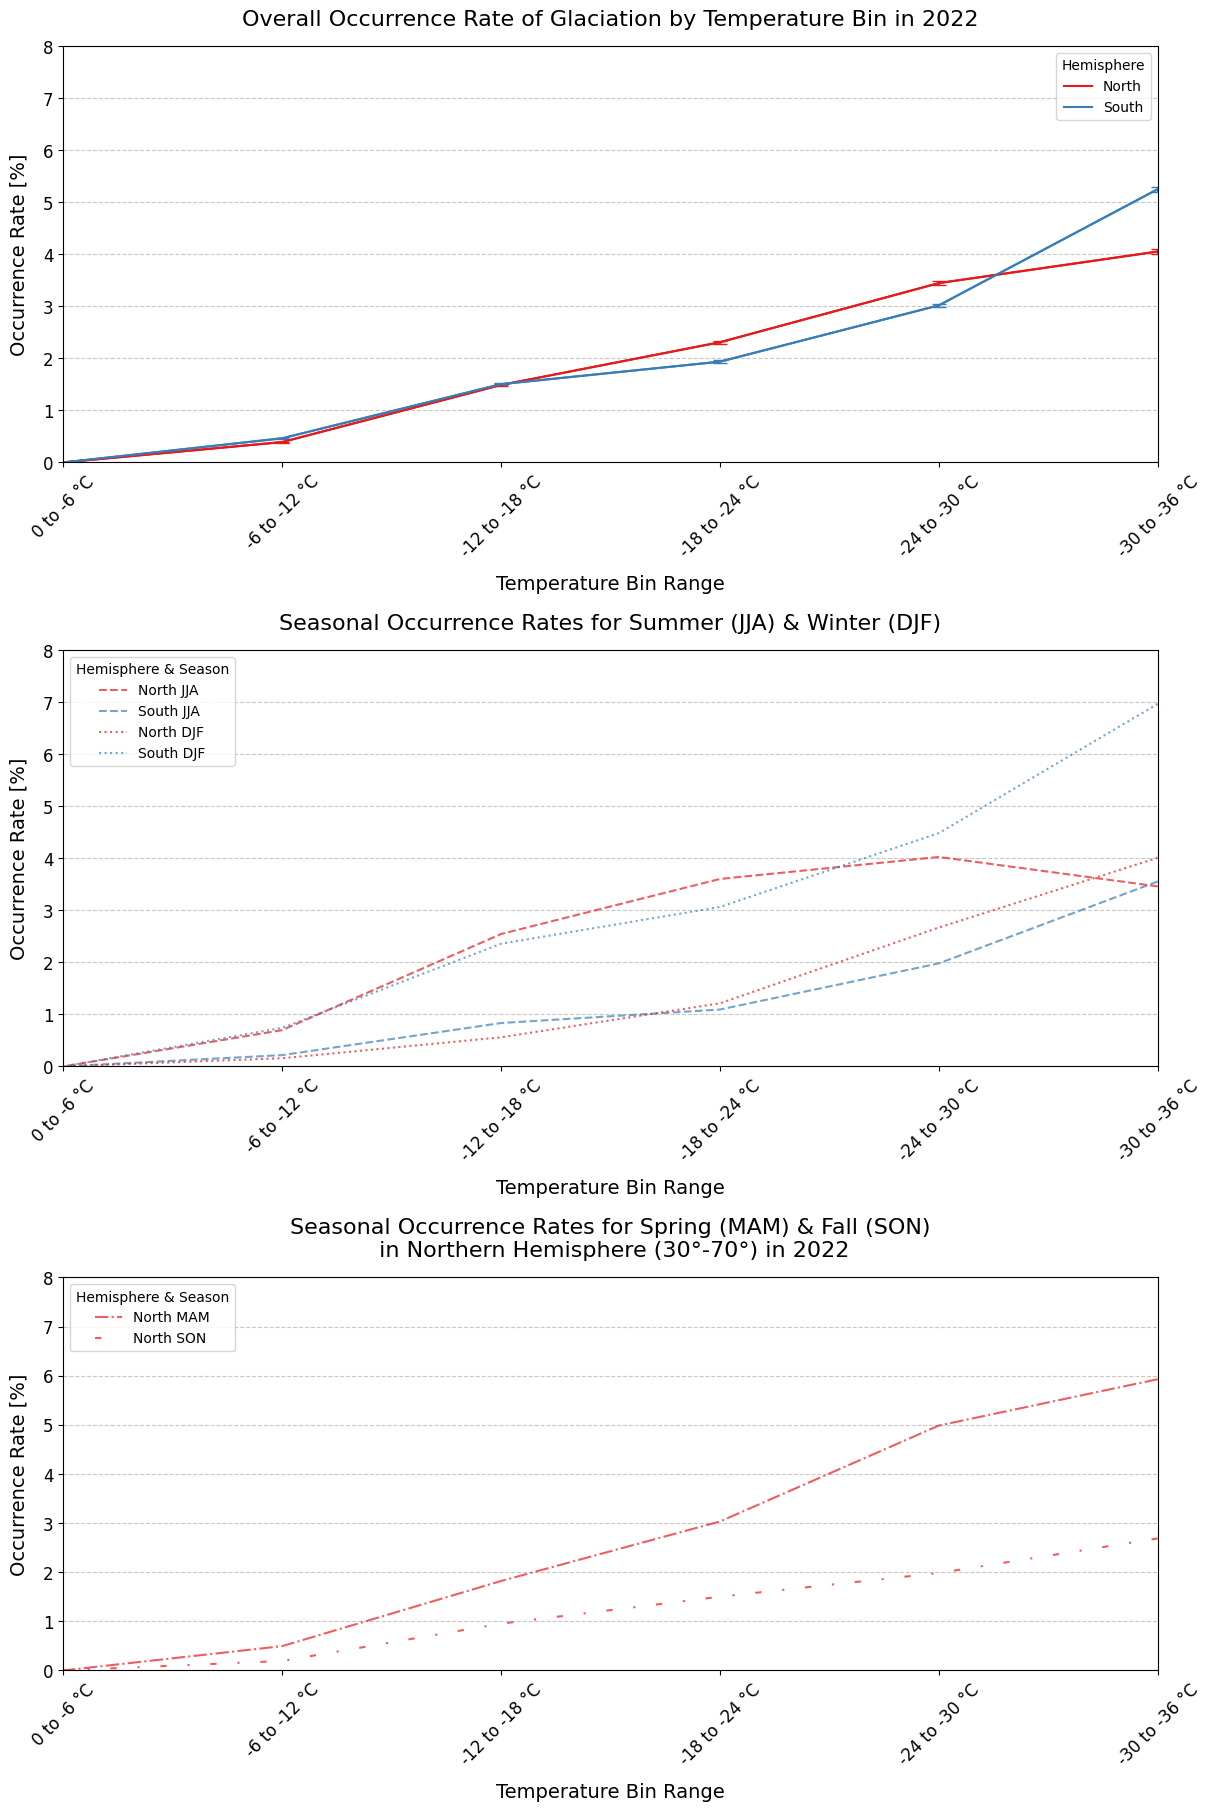

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Assuming glaciating_clouds, combined_cloud_df, classifiacation_palette, and GTE_DIR are already defined

# Define season-specific kernels
summer_glac_kernel = glaciating_clouds["Season"] == "JJA"
summer_comb_kernel = combined_cloud_df["Season"] == "JJA"

winter_glac_kernel = glaciating_clouds["Season"] == "DJF"
winter_comb_kernel = combined_cloud_df["Season"] == "DJF"

spring_glac_kernel = glaciating_clouds["Season"] == "MAM"
spring_comb_kernel = combined_cloud_df["Season"] == "MAM"

fall_glac_kernel = glaciating_clouds["Season"] == "SON"
fall_comb_kernel = combined_cloud_df["Season"] == "SON"

# Define hemisphere kernels
northern_glac_kernel = glaciating_clouds["Hemisphere"] == "North"
southern_glac_kernel = glaciating_clouds["Hemisphere"] == "South"
northern_comb_kernel = combined_cloud_df["Hemisphere"] == "North"
southern_comb_kernel = combined_cloud_df["Hemisphere"] == "South"

# Calculate overall occurrence rates
occurrence_rate_north = (
    glaciating_clouds[northern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south = (
    glaciating_clouds[southern_glac_kernel]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for JJA and DJF
occurrence_rate_north_summer = (
    glaciating_clouds[(northern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_summer = (
    glaciating_clouds[(southern_glac_kernel) & (summer_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & summer_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_winter = (
    glaciating_clouds[(northern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_winter = (
    glaciating_clouds[(southern_glac_kernel) & (winter_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & winter_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Calculate seasonal occurrence rates for MAM and SON
occurrence_rate_north_spring = (
    glaciating_clouds[(northern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_spring = (
    glaciating_clouds[(southern_glac_kernel) & (spring_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & spring_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

occurrence_rate_north_fall = (
    glaciating_clouds[(northern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[northern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)
occurrence_rate_south_fall = (
    glaciating_clouds[(southern_glac_kernel) & (fall_glac_kernel)]["min_temp"].value_counts(sort=False) /
    combined_cloud_df[southern_comb_kernel & fall_comb_kernel]["min_temp"].value_counts(sort=False) * 100
)

# Replace NaN values with 0
occurrence_rate_north = occurrence_rate_north.fillna(0)
occurrence_rate_south = occurrence_rate_south.fillna(0)
occurrence_rate_north_summer = occurrence_rate_north_summer.fillna(0)
occurrence_rate_south_summer = occurrence_rate_south_summer.fillna(0)
occurrence_rate_north_winter = occurrence_rate_north_winter.fillna(0)
occurrence_rate_south_winter = occurrence_rate_south_winter.fillna(0)
occurrence_rate_north_spring = occurrence_rate_north_spring.fillna(0)
occurrence_rate_south_spring = occurrence_rate_south_spring.fillna(0)
occurrence_rate_north_fall = occurrence_rate_north_fall.fillna(0)
occurrence_rate_south_fall = occurrence_rate_south_fall.fillna(0)

# Calculate error bars for overall occurrence rates
error_np = np.sqrt(occurrence_rate_north/100 * (1 - occurrence_rate_north/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="North"]["min_temp"].value_counts(sort=False)) * 100
error_sp = np.sqrt(occurrence_rate_south/100 * (1 - occurrence_rate_south/100) / 
                   combined_cloud_df[combined_cloud_df["Hemisphere"]=="South"]["min_temp"].value_counts(sort=False)) * 100

# Create bin ranges for the x-axis
bin_ranges = [f"{int(temp+6)} to {int(temp)} °C" for temp in occurrence_rate_north.index]

# Create main figure with three subfigures
fig = plt.figure(constrained_layout=True, figsize=(12, 18))
subfigs = fig.subfigures(nrows=3, ncols=1)

# --- First Subfigure: Overall Occurrence Rates ---
ax1 = subfigs[0].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north.values, ax=ax1, label="North", color=classifiacation_palette[0])
sns.lineplot(x=bin_ranges, y=occurrence_rate_south.values, ax=ax1, label="South", color=classifiacation_palette[1])
ax1.errorbar(bin_ranges, occurrence_rate_north.values, yerr=error_np, color=classifiacation_palette[0], capsize=5)
ax1.errorbar(bin_ranges, occurrence_rate_south.values, yerr=error_sp, color=classifiacation_palette[1], capsize=5)
ax1.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax1.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax1.set_title("Overall Occurrence Rate of Glaciation by Temperature Bin in 2022", fontsize=16, pad=15)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.tick_params(axis='x', labelsize=12, rotation=45)
ax1.tick_params(axis='y', labelsize=12)
ax1.set_ylim(0,8)
ax1.set_xlim(0,5)
ax1.invert_xaxis()
ax1.legend(title="Hemisphere")

# --- Second Subfigure: Seasonal Occurrence Rates (JJA & DJF) ---
ax2 = subfigs[1].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_summer.values, ax=ax2, label="North JJA", color=classifiacation_palette[0], linestyle="--", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_summer.values, ax=ax2, label="South JJA", color=classifiacation_palette[1], linestyle="--", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_winter.values, ax=ax2, label="North DJF", color=classifiacation_palette[0], linestyle=":", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_south_winter.values, ax=ax2, label="South DJF", color=classifiacation_palette[1], linestyle=":", alpha=0.7)
ax2.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax2.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax2.set_title("Seasonal Occurrence Rates for Summer (JJA) & Winter (DJF)", fontsize=16, pad=15)
ax2.grid(axis='y', linestyle='--', alpha=0.7)
ax2.tick_params(axis='x', labelsize=12, rotation=45)
ax2.tick_params(axis='y', labelsize=12)
ax2.set_ylim(0,8)
ax2.set_xlim(0,5)
ax2.invert_xaxis()
ax2.legend(title="Hemisphere & Season", loc="upper left")

# --- Third Subfigure: Seasonal Occurrence Rates (MAM & SON) ---
ax3 = subfigs[2].subplots()
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_spring.values, ax=ax3, label="North MAM", color=classifiacation_palette[0], linestyle="-.", alpha=0.7)
# sns.lineplot(x=bin_ranges, y=occurrence_rate_south_spring.values, ax=ax3, label="South MAM", color=classifiacation_palette[1], linestyle="-.", alpha=0.7)
sns.lineplot(x=bin_ranges, y=occurrence_rate_north_fall.values, ax=ax3, label="North SON", color=classifiacation_palette[0], linestyle=(0, (3, 10, 1, 10)), alpha=0.7)
# sns.lineplot(x=bin_ranges, y=occurrence_rate_south_fall.values, ax=ax3, label="South SON", color=classifiacation_palette[1], linestyle=(0, (3, 10, 1, 10)), alpha=0.7)
ax3.set_xlabel("Temperature Bin Range", fontsize=14, labelpad=10)
ax3.set_ylabel("Occurrence Rate [%]", fontsize=14, labelpad=10)
ax3.set_title("Seasonal Occurrence Rates for Spring (MAM) & Fall (SON)\n in Northern Hemisphere (30°-70°) in 2022", fontsize=16, pad=15)
ax3.grid(axis='y', linestyle='--', alpha=0.7)
ax3.tick_params(axis='x', labelsize=12, rotation=45)
ax3.tick_params(axis='y', labelsize=12)
ax3.set_ylim(0,8)
ax3.set_xlim(0,5)
ax3.invert_xaxis()
ax3.legend(title="Hemisphere & Season", loc="upper left")

# Save the overall figure
plt.savefig(os.path.join(GTE_DIR, "Result_graphs/Glaciation_occurance_rates_by_pole_and_spring_vs_autumn.png"), dpi=400)
plt.show()
